# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, lin_reg, simulate_quant_trait
from models import no_corr, rare_pc, pc, gc, abyss_bottle_linreg, abyss_maf_linreg
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats

warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'seaborn'

In [2]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks"
}

# Load genotype

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

NameError: name 'parse_variables' is not defined

In [4]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
name_risk

NameError: name 'get_risk_level' is not defined

In [5]:
nr_common_PCs = 5
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
nr_rare_PCs = 5
rare_pc_columns = ['PC{}'.format(i) for i in range(1, nr_rare_PCs+1)]

In [6]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [7]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)

# Load environmental risk

In [8]:
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")

# Create phenotype only ENV dependent

In [13]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk])))
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

# Analysis

In [10]:
# No correction
df_no_corr = no_corr(complete, y)

In [11]:
# rare PCA
PC_veryrare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
df_rare_PCs = rare_pc(complete, y , PC_veryrare, rare_pc_columns)

In [12]:
# PCA
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
df_PCs = rare_pc(complete, y , PC_common, pc_columns)

In [13]:
# Genomic control
df_GC = gc(df_no_corr)

In [17]:
# minimalist abyss
bottleneck_nr = 2
epoch = 5
patience = 2
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
autoencoder, bottleneck_model, history = abyss(complete*2 - 1, bottleneck_nr, epoch, patience)

abyss_bottle = bottleneck_model(tf.convert_to_tensor(complete*2 - 1, dtype=tf.float32))
abyss_MAF = autoencoder(tf.convert_to_tensor(complete*2 - 1, dtype=tf.float32))
probmaf = (pd.DataFrame(data=abyss_MAF, columns = complete.columns)+1)/2

df_abyss_bottle = abyss_bottle_linreg(complete, y, abyss_bottle)
df_abyss_maf = abyss_maf_linreg(complete, y, probmaf)

,coeff,AFs,Ps_abyss_maf,expected_P,logPs_abyss_maf,expected_logP
0,-0.064727,0.296425,7.446390e-08,0.001159,0.000383,-0.000000
1,0.007621,0.21885,7.105215e-06,0.002317,0.001704,0.000504
2,-0.000402,0.21275,1.744526e-05,0.003476,0.001933,0.001008
3,-0.017530,0.2368,2.568836e-05,0.004635,0.001950,0.001512
4,0.003380,0.217525,4.668449e-05,0.005794,0.003080,0.002018
...,...,...,...,...,...,...
858,0.059531,0.016075,9.929324e-01,0.995365,4.330827,2.237041
859,-0.170837,0.0108,9.955195e-01,0.996524,4.590264,2.333951
860,-0.158448,0.008,9.955583e-01,0.997683,4.758323,2.458890
861,-0.162501,0.010525,9.960850e-01,0.998841,5.148423,2.634981


In [34]:
# minimalist abyss
bottleneck_nr = 2
epoch = 100
patience = 2
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]

deep_autoencoder, deep_bottleneck_model, deep_history = deep_abyss(complete*2 - 1, bottleneck_nr, epoch, patience, risk[[name_risk]])
[deep_abyss_MAF, deep_abyss_pred] = deep_autoencoder(tf.convert_to_tensor(complete*2 - 1, dtype=tf.float32))
deep_abyss_bottle = deep_bottleneck_model(tf.convert_to_tensor(complete*2 - 1, dtype=tf.float32))

In [35]:
bottle_df = pd.DataFrame(deep_abyss_bottle, columns=dim_columns)
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
populations['population'] = populations['population_number']/(k*k)
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
bottle_df[to_have_collumns] = populations[to_have_collumns]

In [36]:
from scipy.stats import entropy
# Function to calculate entropy of a column
def calculate_entropy(column):
    counts = column.value_counts()
    return entropy(counts)

temp = bottle_df.round(2)
# Calculate entropy for each column
entropy_values = temp.apply(calculate_entropy)

# Rank the columns based on entropy
ranked_columns_entropy = entropy_values.sort_values(ascending=False)
most_explaining_dims = list(ranked_columns_entropy.keys())
most_explaining_dims = [f for f in most_explaining_dims if f.startswith('dim')]

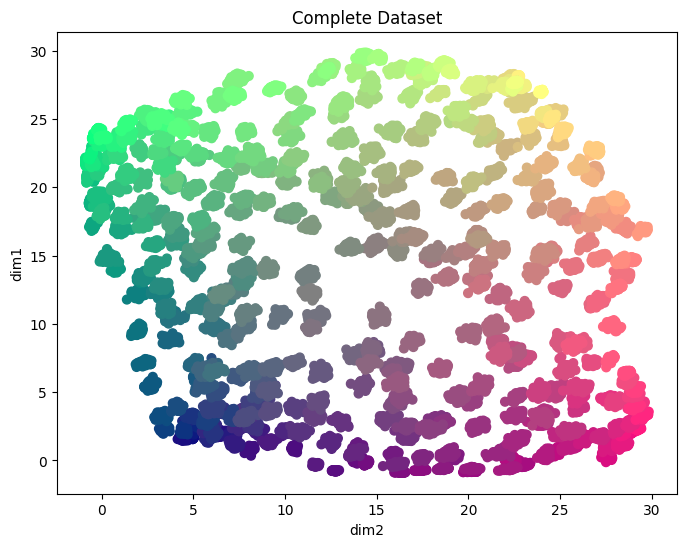

In [37]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_df) for x, y, z in zip(bottle_df['x'], bottle_df['y'], bottle_df['z'])]
plt.scatter(x=bottle_df[most_explaining_dims[0]], y=bottle_df[most_explaining_dims[1]], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel(f"{most_explaining_dims[0]}")
plt.ylabel(f"{most_explaining_dims[1]}")

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

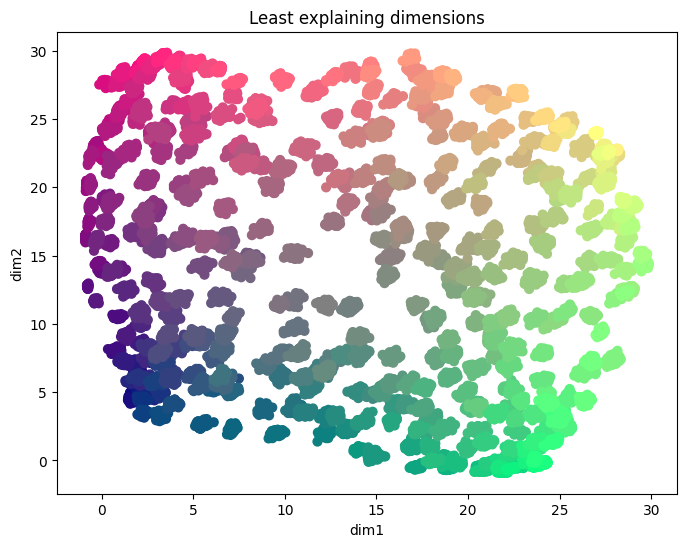

In [41]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_df) for x, y, z in zip(bottle_df['x'], bottle_df['y'], bottle_df['z'])]
plt.scatter(x=bottle_df[most_explaining_dims[-1]], y=bottle_df[most_explaining_dims[-2]], c=colors, s=40)

plt.title('Least explaining dimensions')  # Set the title for the plot
plt.xlabel(f"{most_explaining_dims[-1]}")
plt.ylabel(f"{most_explaining_dims[-2]}")

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

In [42]:
deep_abyss_pred

<tf.Tensor: shape=(20000, 1), dtype=float32, numpy=
array([[0.24296327],
       [0.24551085],
       [0.24302353],
       ...,
       [0.23502488],
       [0.23571207],
       [0.2357485 ]], dtype=float32)>

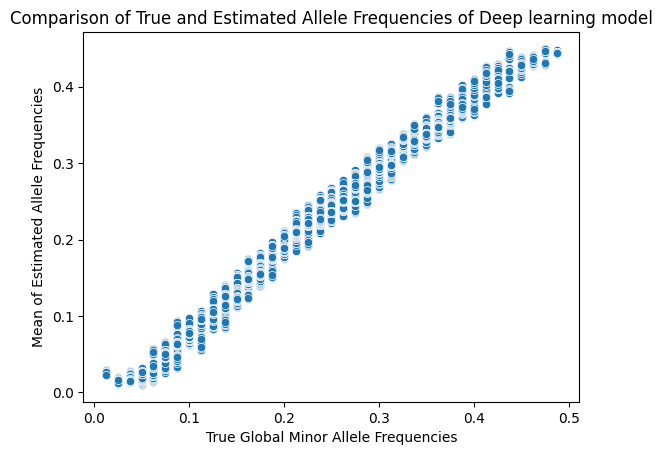

In [57]:
sns.scatterplot(x=list(risk[name_risk]), y=list(np.array(deep_abyss_pred).flatten().tolist()))
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies of Deep learning model')
plt.show()

In [58]:
y

array([ 0.1814924 , -1.04304222,  1.08067088, ..., -1.08443247,
        0.69069408,  0.61038684])

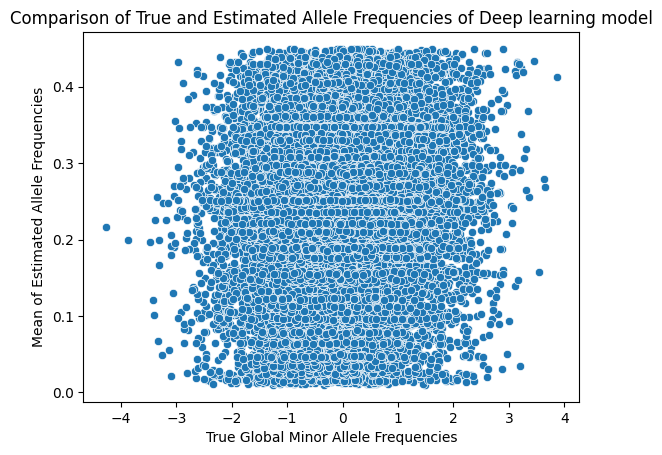

In [59]:
sns.scatterplot(x=list(y), y=list(np.array(deep_abyss_pred).flatten().tolist()))
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies of Deep learning model')
plt.show()

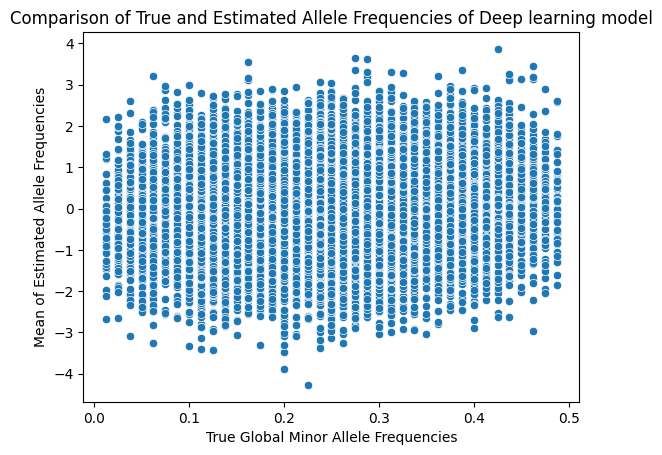

In [62]:
sns.scatterplot(x=list(risk[name_risk]), y=list(y))
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies of Deep learning model')
plt.show()

In [ ]:
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk])))


In [63]:
risk[name_risk]

0        0.25
1        0.25
2        0.25
3        0.25
4        0.25
         ... 
19995    0.25
19996    0.25
19997    0.25
19998    0.25
19999    0.25
Name: NW_risk, Length: 20000, dtype: float64

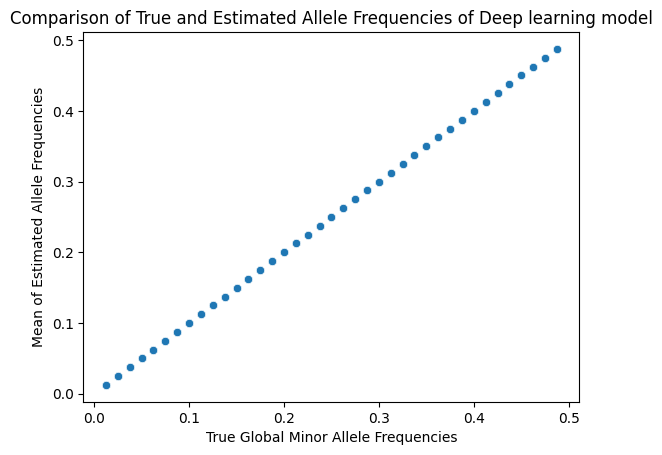

In [64]:
sns.scatterplot(x=list(risk[name_risk]), y=list(risk[name_risk]))
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies of Deep learning model')
plt.show()

In [66]:
# Example original data (for demonstration)
data = pd.Series([0.1, 0.2, 0.3, 0.4, 0.5] * 4000, name="NW_risk")

# Parameters
std_deviation = 0.05  # Define a standard deviation for the randomness

# Generate continuous phenotype
continuous_phenotype = np.random.normal(loc=data.values, scale=std_deviation)

# Convert to pandas Series for consistency
continuous_phenotype_series = pd.Series(continuous_phenotype, name="Continuous_Phenotype")

# Display the first few values
print(continuous_phenotype_series.head())

0    0.127448
1    0.173459
2    0.293570
3    0.472597
4    0.508262
Name: Continuous_Phenotype, dtype: float64
